In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.patches as mpatches

from scipy.stats import mannwhitneyu
import itertools

In [2]:
import json

with open('colors.json', 'r') as f:
    color_dict = json.load(f)

In [3]:
import sys 
sys.path.append('../../src')

from spaceoracle.oracles import BaseTravLR
from spaceoracle.plotting.cartography import Cartography


In [4]:
adata_control = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata_ko = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
adata_ko2 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')


In [5]:
transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymph1_transferred.txt', dtype=str)
ko_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO4_transferred.txt', dtype=str)
ko2_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO2_transferred.txt', dtype=str)

# Remove the Tregs from the transferred list since the correct proportion is low

transferred = [cell for cell in transferred if adata_control.obs.loc[cell, 'cell_type'] != 'Treg']
ko_transferred = [cell for cell in ko_transferred if adata_ko.obs.loc[cell, 'cell_type'] != 'Treg']
ko2_transferred = [cell for cell in ko2_transferred if adata_ko2.obs.loc[cell, 'cell_type'] != 'Treg']

len(transferred), len(ko_transferred), len(ko2_transferred)

(176, 172, 198)

In [6]:
adata_control.X = adata_control.layers['normalized_count']
adata_ko.X = adata_ko.layers['normalized_count']
adata_ko2.X = adata_ko2.layers['normalized_count']

adata_control.obs['tissue'] = 'lymph1'
adata_ko.obs['tissue'] = 'lymphKO4'
adata_ko2.obs['tissue'] = 'lymphKO2'

In [7]:
lymph1_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymph1_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko2_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO2_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko4_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO4_visiumHD_banksy_annotated_zones.csv', index_col=0)

lymph1_banksy_df.index = lymph1_banksy_df.index.astype(str)
lymphko2_banksy_df.index = lymphko2_banksy_df.index.astype(str)
lymphko4_banksy_df.index = lymphko4_banksy_df.index.astype(str)


In [8]:
adata_control.obs['banksy_cluster'] = lymph1_banksy_df['banksy_cluster']
adata_ko.obs['banksy_cluster'] = lymphko4_banksy_df['banksy_cluster']
adata_ko2.obs['banksy_cluster'] = lymphko2_banksy_df['banksy_cluster']

adata_control.obs['1DER_cell_type'] = np.where(adata_control.obs.index.isin(transferred), adata_control.obs['cell_type'], 'NA')
adata_ko.obs['1DER_cell_type'] = np.where(adata_ko.obs.index.isin(ko_transferred), adata_ko.obs['cell_type'], 'NA')
adata_ko2.obs['1DER_cell_type'] = np.where(adata_ko2.obs.index.isin(ko2_transferred), adata_ko2.obs['cell_type'], 'NA')

adata_control.obs['1DER_cell_type'] = '1DER ' + adata_control.obs['1DER_cell_type'].astype(str)
adata_ko.obs['1DER_cell_type'] = '1DER ' + adata_ko.obs['1DER_cell_type'].astype(str)
adata_ko2.obs['1DER_cell_type'] = '1DER ' + adata_ko2.obs['1DER_cell_type'].astype(str)


In [9]:
from scipy.spatial import cKDTree

def get_b_neighbors(adata, radius=30, use_1der=False):
    # b_idx = adata.obs_names[adata.obs['cell_type'] == 'B']
    # b_coords = adata[adata.obs['cell_type'] == 'B'].obsm['spatial']

    b_idx = adata.obs_names[adata.obs['cell_type'] == 'CD8+ T']
    b_coords = adata[adata.obs['cell_type'] == 'CD8+ T'].obsm['spatial']
    
    # b_idx = adata.obs_names
    # b_coords = adata.obsm['spatial']

    if use_1der:
        t_idx = adata.obs_names[adata.obs['1DER_cell_type'] == '1DER Th2']
        t_coords = adata[adata.obs['1DER_cell_type'] == '1DER Th2'].obsm['spatial']
    else:
        t_idx = adata.obs_names[adata.obs['cell_type'] == 'Th2']
        t_coords = adata[adata.obs['cell_type'] == 'Th2'].obsm['spatial']
        

    b_tree = cKDTree(b_coords)

    b_near_t = {}
    for i, (t_name, t_coord) in enumerate(zip(t_idx, t_coords)):
        idxs = b_tree.query_ball_point(t_coord, r=radius)
        b_near_t[t_name] = list(b_idx[idxs])

    return b_near_t

def get_bdata(adata, radius=30):

    b_near_t = get_b_neighbors(adata, radius)

    gex_df = adata.to_df(layer='normalized_count')

    b_neighbors = {}
    for cell, gex in b_near_t.items():
        b_neighbors[cell] = gex_df.loc[b_near_t[cell]].mean()

    b_neighbors = pd.DataFrame(b_neighbors).T

    b_neighbors = sc.AnnData(
        X = b_neighbors.values,
        obs = adata.obs.loc[b_neighbors.index],
        var = pd.DataFrame(index=b_neighbors.columns)
    )

    b_neighbors.X = np.nan_to_num(b_neighbors.X, nan=0)

    # 1DER Th2: transferred
    # 1DER NA: polyclonal

    sc.tl.rank_genes_groups(
        b_neighbors,
        groupby='1DER_cell_type',
        method='wilcoxon',
        use_raw=False, 
        reference='1DER NA'
    )

    degs = sc.get.rank_genes_groups_df(b_neighbors, group='1DER Th2')
    return degs


In [10]:
degs_ko2 = get_bdata(adata_ko2)
degs_ko4 = get_bdata(adata_ko)
degs_control = get_bdata(adata_control)

degs = pd.merge(degs_ko2, degs_ko4, on='names', how='outer', suffixes=('_2', '_4'))
degs = pd.merge(degs, degs_control, on='names', how='outer', suffixes=('ko', '_control'))

degs

,names,scores_2,logfoldchanges_2,pvals_2,pvals_adj_2,scores_4,logfoldchanges_4,pvals_4,pvals_adj_4,scores,logfoldchanges,pvals,pvals_adj
0,Adam11,-0.074587,-0.496062,0.940543,1.0,0.506977,2.169681,0.612171,1.0,-0.398878,-1.500077,0.689983,1.0
1,Adam12,0.023027,-0.396615,0.981629,1.0,0.164394,1.414448,0.869421,1.0,-0.232177,-0.350669,0.816401,1.0
2,Adam23,0.062072,-0.151078,0.950505,1.0,0.174166,-0.503058,0.861735,1.0,-0.655960,-0.936503,0.511850,1.0
3,Adam8,-0.104122,-0.510768,0.917073,1.0,0.151748,0.076593,0.879385,1.0,0.092389,0.036024,0.926389,1.0
4,Adamts10,1.602871,1.119115,0.108963,1.0,0.199457,-0.123358,0.841905,1.0,0.841541,0.513344,0.400045,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111,Zmynd12,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,1.000000,1.0
2112,Zmynd15,0.129151,-0.452281,0.897238,1.0,0.455245,0.544415,0.648933,1.0,-0.935938,-0.804922,0.349305,1.0
2113,Znfx1,0.402970,0.832022,0.686970,1.0,0.286252,0.581134,0.774685,1.0,0.365136,0.612113,0.715010,1.0
2114,Znhit2,-0.001502,-0.078948,0.998802,1.0,0.264985,0.935963,0.791021,1.0,-0.191204,-0.871996,0.848365,1.0


In [11]:
degs['scores_ko'] = degs['scores_2'] + degs['scores_4']
degs['logfoldchanges_ko'] = degs['logfoldchanges_2'] + degs['logfoldchanges_4']

degs.sort_values(by='scores_ko', ascending=False, inplace=True)

In [12]:
degs = degs[
    ((degs['logfoldchanges_2'] > 0) & (degs['logfoldchanges_4'] > 0)) 
    | ((degs['logfoldchanges_2'] < 0) & (degs['logfoldchanges_4'] < 0))
]
degs['logfoldchanges_ko_min'] = degs[['logfoldchanges_2', 'logfoldchanges_4']].min(axis=1)
degs['logfoldchanges_ko_max'] = degs[['logfoldchanges_2', 'logfoldchanges_4']].max(axis=1)

In [13]:
# top_5 = degs[degs['logfoldchanges_ko'] > 0].sort_values(by='logfoldchanges_ko', ascending=False)
# bottom_5 = degs[degs['logfoldchanges_ko'] < 0].sort_values(by='logfoldchanges_ko', ascending=True)

In [14]:
top_5 = degs[
    (degs['logfoldchanges_ko'] > 0) & (degs['logfoldchanges_ko_min'] > degs['logfoldchanges'] +0.1)
].sort_values(by='scores_ko', ascending=False)

bottom_5 = degs[
    (degs['logfoldchanges_ko'] < 0) & (degs['logfoldchanges_ko_max'] < degs['logfoldchanges'] -0.1)
].sort_values(by='scores_ko', ascending=True)

In [60]:
def make_b_adata(b_near_t, adata):
    b_neighbors = {}
    gex_df = adata.to_df(layer='normalized_count')
    for cell, gex in b_near_t.items():
        b_neighbors[cell] = gex_df.loc[b_near_t[cell]].mean()

    b_neighbors = pd.DataFrame(b_neighbors).T

    b_neighbors = sc.AnnData(
        X = b_neighbors.values,
        obs = adata.obs.loc[b_neighbors.index],
        var = pd.DataFrame(index=b_neighbors.columns)
    )
    b_neighbors.X = np.nan_to_num(b_neighbors.X, nan=0)

    return b_neighbors


def get_consistent_degs(adata_control, adata_ko, adata_ko2, top_5, bottom_5, use_1der=False):

    b_control = get_b_neighbors(adata_control, use_1der=use_1der)
    b_ko = get_b_neighbors(adata_ko, use_1der=use_1der)
    b_ko2 = get_b_neighbors(adata_ko2, use_1der=use_1der)

    # # Use individual cells 
    # b_control = sc.concat([adata_control[v, :] for k, v in b_control.items()], axis=0)
    # b_ko = sc.concat([adata_ko[v, :] for k, v in b_ko.items()], axis=0)
    # b_ko2 = sc.concat([adata_ko2[v, :] for k, v in b_ko2.items()], axis=0)

    # Use mean expression of neighbors
    b_control = make_b_adata(b_control, adata_control)
    b_ko = make_b_adata(b_ko, adata_ko)
    b_ko2 = make_b_adata(b_ko2, adata_ko2)

    adata_b = sc.AnnData(
        X = np.concatenate([b_control.X, b_ko.X, b_ko2.X], axis=0),
        var = b_control.var,
        obs = pd.concat([b_control.obs, b_ko.obs, b_ko2.obs], axis=0)
    )

    sc.tl.rank_genes_groups(adata_b, groupby='tissue', method='wilcoxon', use_raw=False, reference='lymph1')
    degs_ko4 = sc.get.rank_genes_groups_df(adata_b, group='lymphKO4')   
    degs_ko2 = sc.get.rank_genes_groups_df(adata_b, group='lymphKO2')

    degs_consistent = pd.merge(degs_ko4, degs_ko2, on='names', how='inner', suffixes=('_ko4', '_ko2'))
    degs_consistent = degs_consistent[degs_consistent['logfoldchanges_ko4'] * degs_consistent['logfoldchanges_ko2'] > 0]
    top_5_consistent = degs_consistent[degs_consistent['names'].isin(top_5['names'])]
    top_5_consistent = top_5_consistent[top_5_consistent['logfoldchanges_ko4'] > 0]
    top_5_consistent['scores_ko'] = top_5_consistent['scores_ko4'] + top_5_consistent['scores_ko2']

    bottom_5_consistent = degs_consistent[degs_consistent['names'].isin(bottom_5['names'])]
    bottom_5_consistent = bottom_5_consistent[bottom_5_consistent['logfoldchanges_ko4'] < 0]
    bottom_5_consistent['scores_ko'] = bottom_5_consistent['scores_ko4'] + bottom_5_consistent['scores_ko2']

    top_5_consistent = top_5_consistent[top_5_consistent['names'].isin(top_5['names'])]
    bottom_5_consistent = bottom_5_consistent[bottom_5_consistent['names'].isin(bottom_5['names'])]

    return top_5_consistent, bottom_5_consistent


In [61]:
top_5_all, bottom_5_all = get_consistent_degs(adata_control, adata_ko, adata_ko2, top_5.copy(), bottom_5.copy())
top_5_1der, bottom_5_1der = get_consistent_degs(adata_control, adata_ko, adata_ko2, top_5.copy(), bottom_5.copy(), use_1der=True)

In [62]:
top = pd.merge(top_5_all, top_5_1der, on='names', how='outer', suffixes=('_all', '_1der'))
top['pvals_min'] = top[['pvals_ko2_1der', 'pvals_ko4_1der', 'pvals_ko2_all', 'pvals_ko4_all']].min(axis=1)
top.sort_values(by='pvals_min', ascending=True, inplace=True)
top.head(20)['names'].tolist()


['Dtx3l',
 'Paxbp1',
 'Gata3',
 'Fnbp4',
 'Aif1',
 'Pea15a',
 'Utrn',
 'Ctsw',
 'Il7r',
 'Bcl2l12',
 'Parp14',
 'Atp5e',
 'Tmem179b',
 'Vgll4',
 'Tnfsf10',
 'Rab11fip1',
 'Cxcl16',
 'Sgf29',
 'Pik3ip1',
 'Icam1']

In [63]:
bottom = pd.merge(bottom_5_all, bottom_5_1der, on='names', how='outer', suffixes=('_all', '_1der'))
bottom['pvals_max'] = bottom[['pvals_ko2_1der', 'pvals_ko4_1der', 'pvals_ko2_all', 'pvals_ko4_all']].min(axis=1)
bottom.sort_values(by='pvals_max', ascending=True, inplace=True)
bottom.head(20)['names'].tolist()

['Cd79b',
 'Syk',
 'Spn',
 'Cst3',
 'Stat4',
 'Ptms',
 'Plec',
 'Lyst',
 'Stap1',
 'Rab8b',
 'Atp8b2',
 'Cd4',
 'Dnase1l3',
 'Iglc3',
 'Cxcr5',
 'Ccr6',
 'Gramd1a',
 'App',
 'Phf11b',
 'Sh2d1a']

In [64]:
top.to_csv('top_5_all_vs_1der.csv', index=False)
bottom.to_csv('bottom_5_all_vs_1der.csv', index=False)

In [65]:
'''
selection of these genes based on many criteria:
1a. neighborhood averaged gex logfc between 1DER vs polyclonal in each sample
1b. logfoldchanges_ko4 and ko2 for 1DER vs polyclonal > control
2. degs between 1DER control and 1DER KOs
3. consistent direction in all comparisons
4. consistent tissue-wise comparison using 1DER and all Th2 cells
'''

'\nselection of these genes based on many criteria:\n1a. neighborhood averaged gex logfc between 1DER vs polyclonal in each sample\n1b. logfoldchanges_ko4 and ko2 for 1DER vs polyclonal > control\n2. degs between 1DER control and 1DER KOs\n3. consistent direction in all comparisons\n4. consistent tissue-wise comparison using 1DER and all Th2 cells\n'

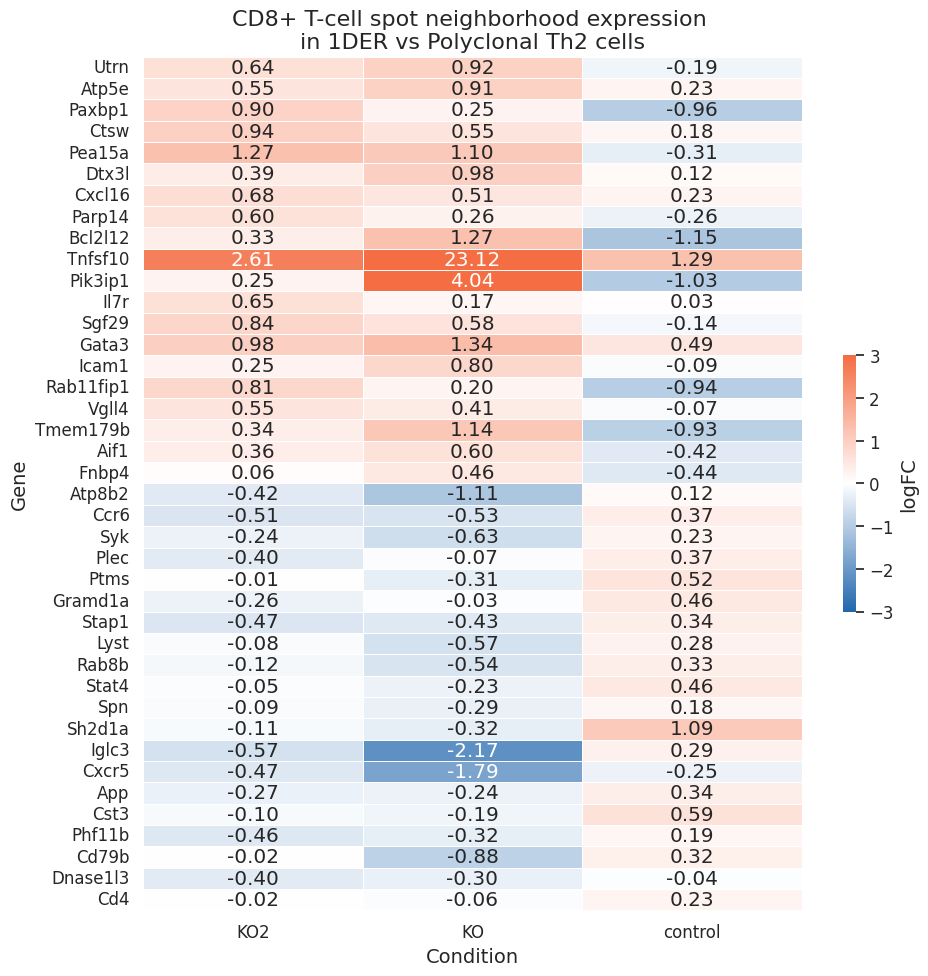

In [69]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a blue-white-orange colormap
blue_orange_cmap = LinearSegmentedColormap.from_list(
    'blue_orange', 
    ['#2166ac', 'white', '#f46d43']  # blue → white → orange
)

# Your existing code to generate the heatmap data
selected_degs = pd.concat([
    top_5[top_5['names'].isin(top.head(20)['names'].tolist())], 
    bottom_5[bottom_5['names'].isin(bottom.head(20)['names'].tolist())]
])

relabel = {
    'logfoldchanges_2': 'KO2',
    'logfoldchanges_4': 'KO',
    'logfoldchanges': 'control'
}

# Prepare heatmap data for logfoldchanges
heatmap_data = selected_degs.set_index('names')[['logfoldchanges_2', 'logfoldchanges_4', 'logfoldchanges']]
heatmap_data.columns = [relabel.get(col, col) for col in heatmap_data.columns]

# Prepare annotation data with logfoldchange
def make_annot(row):
    return [
        f"{row['logfoldchanges_2']:.2f}",
        f"{row['logfoldchanges_4']:.2f}",
        f"{row['logfoldchanges']:.2f}"
    ]

annot_data = selected_degs.apply(make_annot, axis=1, result_type='expand')
annot_data.index = selected_degs['names']
annot_data.columns = heatmap_data.columns

# Calculate max value for color scaling
max_abs = np.abs(heatmap_data.values).max()
vmax = min(max_abs, 3)

# Create the heatmap with the custom colormap
plt.figure(figsize=(10, 10))
sns.heatmap(
    heatmap_data,
    annot=annot_data.values,
    fmt='',
    cmap=blue_orange_cmap,  # Use the custom colormap
    center=0,
    linewidths=0.5,
    vmin=-vmax,
    vmax=vmax,
    cbar_kws={'label': 'logFC', 'shrink': 0.3},
)

# Add labels and title
plt.xlabel('Condition')
plt.ylabel('Gene')
plt.title('CD8+ T-cell spot neighborhood expression \nin 1DER vs Polyclonal Th2 cells')

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/cd8_neighborhood_expression_1der_vs_polyclonal_th2.svg', dpi=300, transparent=True, bbox_inches='tight', format='svg')
plt.show()


In [ ]:
top_genes = top.head(20)['names'].tolist()
bottom_genes = bottom.head(20)['names'].tolist()

In [71]:
cd8_adata = adata_control[adata_control.obs['cell_type'] == 'CD8+ T']

sc.tl.score_genes(cd8_adata, gene_list=top_genes, score_name='top5_score', use_raw=False)
sc.tl.score_genes(cd8_adata, gene_list=bottom_genes, score_name='bottom5_score', use_raw=False)

# sc.pl.spatial(cd8_adata, color=['top5_score', 'bottom5_score'], show=False, spot_size=20, layer='normalized_count', cmap='viridis')

/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


In [72]:
import squidpy as sq
sq.gr.spatial_neighbors(cd8_adata)
top_moran = sq.gr.spatial_autocorr(cd8_adata, mode='moran', genes=top_genes, n_perms=100, copy=True)
bottom_moran = sq.gr.spatial_autocorr(cd8_adata, mode='moran', genes=bottom_genes, n_perms=100, copy=True)

  0%|          | 0/100 [00:00<?, ?/s]

  0%|          | 0/100 [00:00<?, ?/s]

/tmp/ipykernel_28073/853867915.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


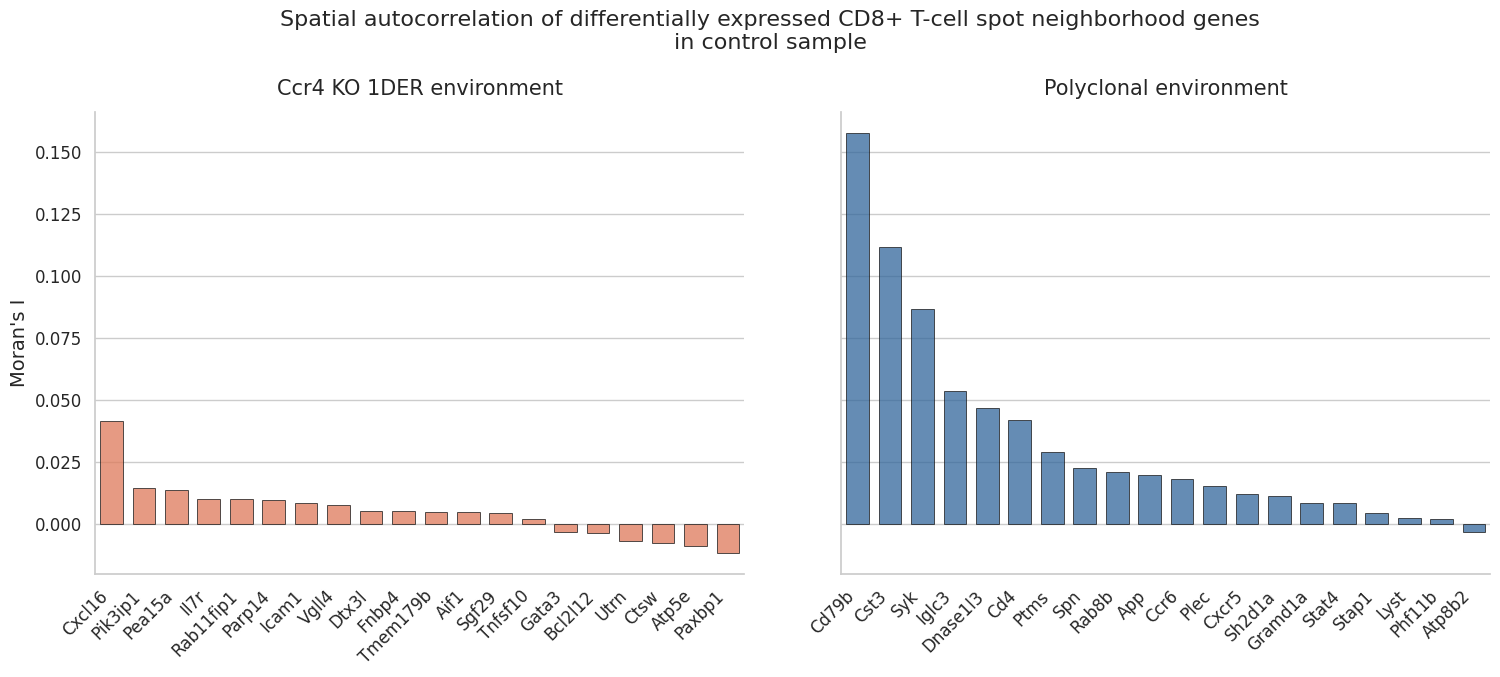

In [73]:
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams.update({'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

top_moran_I = top_moran['I'].values
bottom_moran_I = bottom_moran['I'].values

x = np.arange(len(top_moran.index))

fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True, gridspec_kw={'wspace': 0.15})

bar_kwargs = dict(width=0.7, edgecolor='k', linewidth=0.7)

# Top genes barplot
sns.barplot(x=x, y=top_moran_I, ax=axs[0], color='#f46d43', alpha=0.75, **bar_kwargs)
axs[0].set_xticks(x)
axs[0].set_xticklabels(top_moran.index, rotation=45, ha='right')
axs[0].set_ylabel("Moran's I", fontsize=14)
axs[0].set_title("Ccr4 KO 1DER environment", fontsize=15, pad=12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# Bottom genes barplot
sns.barplot(x=x, y=bottom_moran_I, ax=axs[1], color='#2166ac', alpha=0.75, **bar_kwargs)
axs[1].set_xticks(x)
axs[1].set_xticklabels(bottom_moran.index, rotation=45, ha='right')
axs[1].set_title("Polyclonal environment", fontsize=15, pad=12)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_ylabel("")

# for i, v in enumerate(top_moran_I):
#     axs[0].text(i, v + 0.001, f"{v:.2f}", ha='center', va='bottom', fontsize=10, color='#333333')
# for i, v in enumerate(bottom_moran_I):
#     axs[1].text(i, v + 0.001, f"{v:.2f}", ha='center', va='bottom', fontsize=10, color='#333333')

plt.suptitle("Spatial autocorrelation of differentially expressed CD8+ T-cell spot neighborhood genes\nin control sample", fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('figures/cd8_moran_1der_vs_polyclonal.png', dpi=300)
plt.show()


/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?/s]

/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for thes

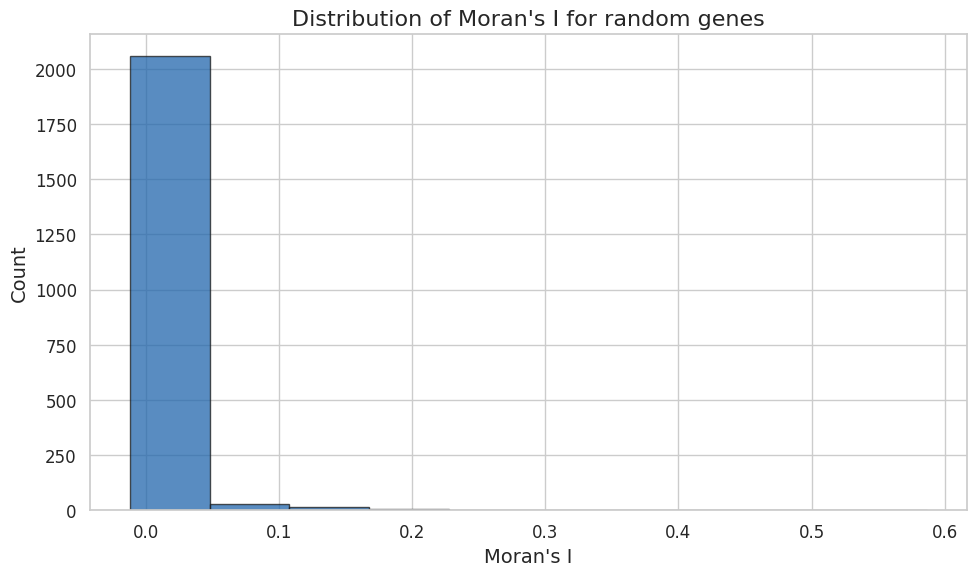

In [74]:
import squidpy as sq

sq.gr.spatial_neighbors(cd8_adata)
baseline = sq.gr.spatial_autocorr(cd8_adata, mode='moran', genes=cd8_adata.var_names, n_perms=100, copy=True)

plt.figure(figsize=(10, 6))
plt.hist(baseline['I'], bins=10, color='#2166ac', alpha=0.75, edgecolor='k')
plt.xlabel("Moran's I")
plt.ylabel("Count")
plt.title("Distribution of Moran's I for random genes")
plt.tight_layout()
plt.show()